<div style="background:#e5e5e5; color:#000; padding:10px">

Привет!\
    Пришел первоначальный проект без моих комментариев и исправлений.
</div> 

Добрый день! Почему проект вернули без комментариев, это же первая итерация? Это не ошибка?

# Проверка гипотез для увеличения выручки интернет-магазина

Имеются данные о гипотезах по увеличению выручки и файлы с результатами A/B-теста (данные о пользователях и заказах). 

Цели: 

- выяснить, какие гипотезы нужно проверить в первую очередь
- принять решение по результатам A/B-теста (нужно продолжать тест или зафиксировать отстутствие различий/победу одной из групп)

Задачи:

- приоритизировать гипотезы, используя фреймворки ICE и RICE
- проанализировать результаты A/B теста

## Приоритизация гипотез

In [1]:
import pandas as pd

In [2]:
hyps = pd.read_csv('/datasets/hypothesis.csv', sep=',')
hyps.columns = hyps.columns.str.lower()
hyps.head()

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


<div class="alert alert-warning">
    
  <b>Комментарий ревьюера</b>
    
  ⚠️ Лучше разделить на ячейки загрузку модулей и загрузку данных, это соответствует РЕР8, а также избавит от невынужденных проблем, если нужно будет подгрузить библиотеку, а в результате произойдет перезапись датасета.

</div>

In [3]:
hyps['ICE'] = (hyps['impact']*hyps['confidence'])/hyps['efforts']

pd.options.display.max_colwidth = 400
display(hyps[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


По ICE наиболее перспективные гипотезы - 9, 1, 8, и 7. 

In [4]:
hyps['RICE'] = (hyps['reach']*hyps['impact']*hyps['confidence'])/hyps['efforts']

display(hyps[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Фреймворки отличаются друг от друга тем, что в RICE учитывается охват - скольких пользователей затронет изменение, которое предпоагается внести. Поэтому по RICE наиболее приоритетными оказались гипотезы 8, 3, 1 и 7. Так произошло, потому что у 3 гипотезы большой показатель reach, а на первом месте оказалась 8 гипотеза, у которой наибольший охват. 

Вывод: с помощью фреймворков выявлены 5 наиболее приоритетных гипотез. Я бы в первую очередь проверила 8 гипотезу, т.к. она  находится в топе обоих рейтингов и у неё большой охват, потом можно обратить внимание на остальные 4 и выбирать в зависимости от того, что важнее - сила или охват.

## Анализ A/B-теста

In [5]:
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()

In [6]:
orders_raw = pd.read_csv('/datasets/orders.csv', sep=',')
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

In [7]:
display(orders_raw.head())
orders_raw.duplicated().sum()
orders_raw.info()

print(orders_raw[orders_raw['group']=='A'].count())
print(orders_raw[orders_raw['group']=='B'].count())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
transactionId    557
visitorId        557
date             557
revenue          557
group            557
dtype: int64
transactionId    640
visitorId        640
date             640
revenue          640
group            640
dtype: int64


In [8]:
#удалим пользователей, которые вошли в обе группы

groups = orders_raw.groupby('visitorId')['group'].nunique().reset_index()
groups = groups.query('group == 246')
orders = groups.merge(orders_raw, how='left', on='user_id')

orders = orders.rename(columns={'group_y': 'group'}) 
orders = orders.drop(columns=['group_x'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1015
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   visitorId      1016 non-null   int64 
 1   transactionId  1016 non-null   int64 
 2   date           1016 non-null   object
 3   revenue        1016 non-null   int64 
 4   group          1016 non-null   object
dtypes: int64(3), object(2)
memory usage: 47.6+ KB


In [9]:
display(visitors.head())
visitors.duplicated().sum()
visitors.info()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Кумулятивная выручка по группам

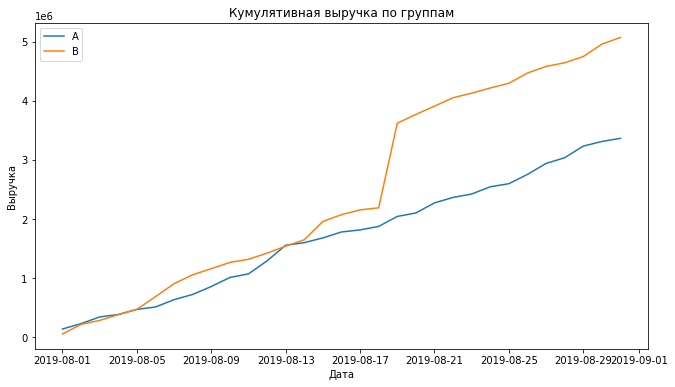

In [10]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(11,6))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend() 
plt.title('Кумулятивная выручка по группам')
plt.xlabel("Дата") 
plt.ylabel("Выручка")
plt.show()

Выручка увеличивается во время всего теста, для группы A - равномерно, для группы B в одной точке есть резкий рост - это может говорить о резком увеличении числа заказов или о наличии выбросов - очень дорогих заказов.

Кумулятивный средний чек по группам

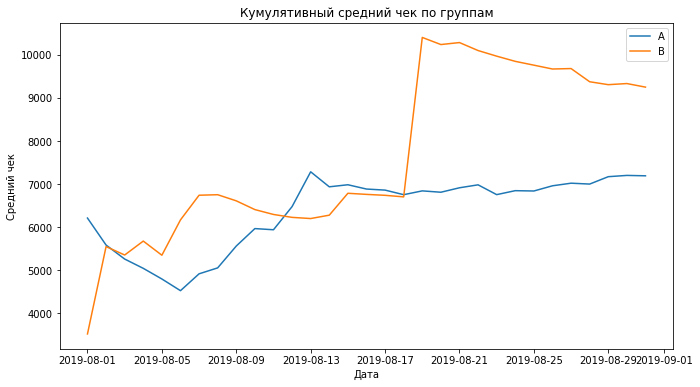

In [11]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][
    ['date', 'revenue', 'orders']
]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][
    ['date', 'revenue', 'orders']
]

plt.figure(figsize=(11,6))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('Кумулятивный средний чек по группам')
plt.xlabel("Дата") 
plt.ylabel("Средний чек")
plt.show()

Средний чек для группы B резко увеличивается приблизительной в той же точке, что и на графике кумулятивной выручки, это подтверждает предположение о том, что в группу попали очень крупные заказы. Для группы A средний чек сначала падал, потом увеличивался и сейчас почти стабилизировался

Относительное изменение кумулятивного среднего чека группы B к группе A

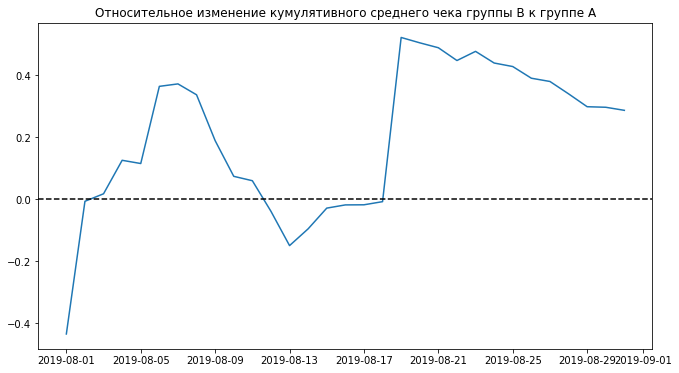

In [12]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(11,6))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.show()

График различия между группами резко скачет в нескольких точках - это говорит о том, что в данных есть выбросы.

Кумулятивная конверсия по группам

(18109.0, 18140.0, 0.0, 0.05)

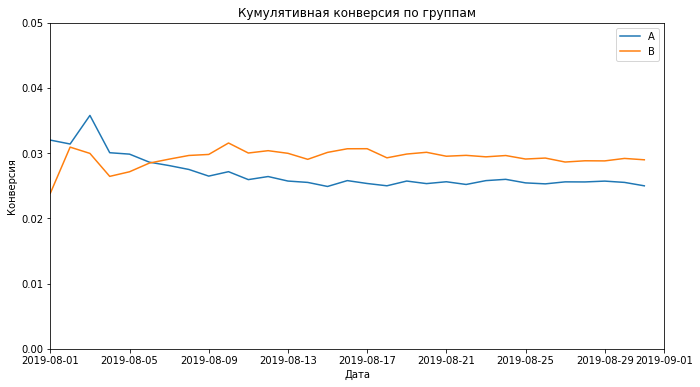

In [13]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize=(11,6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивная конверсия по группам')
plt.xlabel("Дата") 
plt.ylabel("Конверсия")
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])

Группы колебались около одного значения, но затем конверсия группы B вырвалась вперёд, а конверсия группы A просела, и обе конверсии зафиксировались.

Относительное изменение кумулятивной конверсии группы B к группе A

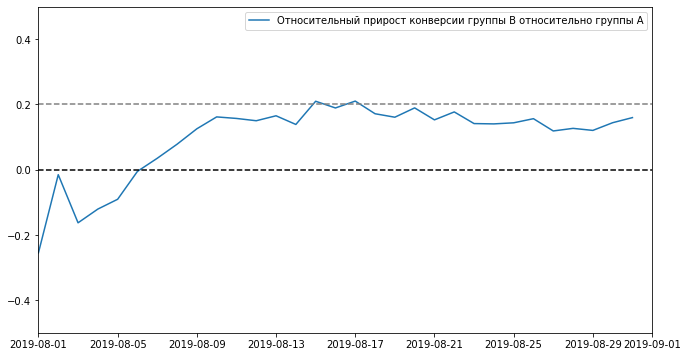

In [14]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


plt.figure(figsize=(11,6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.5, 0.5])
plt.show()

Какое-то время конверсия группы B была даже ниже, чем у группы A, но потом резко увеличилась.

График количества заказов по пользователям

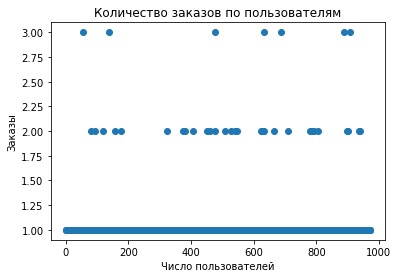

In [15]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']

x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Количество заказов по пользователям')
plt.xlabel("Число пользователей") 
plt.ylabel("Заказы")
plt.show()

Большинство пользователей сделало только один заказ, остальные по два заказа.

Граница для определения аномальных пользователей

In [16]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Больше двух заказов совершило не более 1% пользователей. Примем за аномальных тех пользователей, которые совершили более двух заказов.

График стоимостей заказов

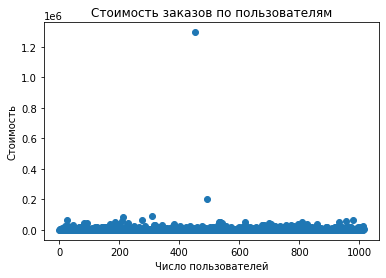

In [17]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.title('Стоимость заказов по пользователям')
plt.xlabel("Число пользователей") 
plt.ylabel("Стоимость")
plt.show()

Есть два очень дорогих заказа. По графику можно выбрать границу аномально дорогих заказов на уровне 200 000 рублей.

Граница для определения аномальных заказов

In [18]:
print(np.percentile(orders['revenue'], [95, 99])) 

[26785. 53904.]


Не более 5% заказов дороже 26785 рублей и не более 1% дороже 53904 рублей. Примем за аномальных тех пользователей, кто совершил заказ на сумму свыше 50 000 рублей.    

Статистическая значимость различий в конверсии между группами по «сырым» данным

Сформулируем нулевую и альтернативную гипотезы:

    H0 - между группами нет статистически значимых различий в конверсии
    H1 - такие различия в конверсии между группами есть.

In [19]:
import scipy.stats as stats

In [20]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.01102


P-value меньше 0.05, значит, по сырым данным отвергаем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.

Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Сформулируем нулевую и альтернативную гипотезы:

    H0 - между группами нет статистически значимых различий в среднем чеке
    H1 - такие различия в среднем чеке между группами есть.

In [21]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

0.829


P-value больше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем чеке между группами нет, не отвергаем.

Статистическая значимость различий в конверсии между группами по «очищенным» данным (после фильтрации проверяем те же самые гипотезы)

In [22]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.00561
0.198


По очищенным данным также отвергаем нулевую гипотезу о равенстве конверсии, конверсия группы B выше почти на 20%.

Статистическая значимость различий в среднем чеке между группами по «очищенным» данным

In [23]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.939
0.011


Значение p-value после удаления аномальных пользователей стало меньше, но всё ещё больше 0.05, значит, статистически значимых различий в среднем чеке между группами нет, и средний чек группы B на 1% больше.

Выводы:

- статистически значимое различие в конверсии между группами есть и по сырым данным, и после применения фильтрации
- конверсия группы B выше, чем группы A
- во второй половине эксперимента обе конверсии стабилизировались
- тест не выявил статистически значимых различий в среднем чеке между группами, но и по этому показателю группа B немного опережает группу A
- тест следует остановить и признать успешным, т.к. по одному показателю сегмент B значительно лучше сегмента A, а по второму различий практически нет. 